In [34]:
import os
import sys
import time
from datetime import datetime as dt
import numpy as np
from matplotlib import pyplot as plt, ticker
from pysar.simulation.plot import *
from pysar.objects import timeseries, ifgramStack, sensor, gps
from pysar.utils import readfile, ptime, plot as pp, writefile, utils as ut

work_dir = '/Users/yunjunz/development/python/2018_ComputGeosci_PySAR/pysar_vs_gps'
os.chdir(work_dir)
print('Go to directory: '+work_dir)

site = 'GV04'
site_r = 'GV01'

gps_dir = '/Users/yunjunz/insarlab/Galapagos/GPS'
pysar_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE'
ts_file = os.path.join(pysar_dir, 'geo_timeseries_ECMWF_demErr_refDate_plane.h5')
atr = readfile.read_attribute(ts_file)

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/pysar_vs_gps


In [36]:
## Read GPS
gps_obj = gps(site=site, data_dir=gps_dir)
gps_obj.open()
gps_times = gps_obj.times
gps_dis = ut.enu2los(gps_obj.dis_e, gps_obj.dis_n, gps_obj.dis_u)

if site_r:
    gps_r_obj = gps(site=site_r, data_dir=gps_dir)
    gps_r_obj.open()
    
    gps_times = sorted(list(set(gps_obj.times) & set(gps_r_obj.times)))
    dis_e = np.zeros(len(gps_times), np.float32)
    dis_n = np.zeros(dis_e.shape, np.float32)
    dis_u = np.zeros(dis_e.shape, np.float32)
    for i in range(len(gps_times)):
        idx1 = gps_obj.times.index(gps_times[i])
        idx2 = gps_r_obj.times.index(gps_times[i])
        dis_e[i] = gps_obj.dis_e[idx1] - gps_r_obj.dis_e[idx2]
        dis_n[i] = gps_obj.dis_n[idx1] - gps_r_obj.dis_n[idx2]
        dis_u[i] = gps_obj.dis_u[idx1] - gps_r_obj.dis_u[idx2]
    gps_dis = ut.enu2los(dis_e, dis_n, dis_u)

## Read InSAR
y = ut.coord_geo2radar(gps_obj.site_lat, atr, 'lat')
x = ut.coord_geo2radar(gps_obj.site_lon, atr, 'lon')
box = (x, y, x+1, y+1)

ts_obj = timeseries(ts_file)
ts_obj.open()
pysar_dis = ts_obj.read(box=box)
pysar_times = ts_obj.times

if site_r:
    y_r = ut.coord_geo2radar(gps_r_obj.site_lat, atr, 'lat')
    x_r = ut.coord_geo2radar(gps_r_obj.site_lon, atr, 'lon')
    box_r = (x_r, y_r, x_r+1, y_r+1)
    pysar_dis -= ts_obj.read(box=box_r)

calculating station lat/lon
reading time and displacement in east/north/vertical direction
open timeseries file: geo_timeseries_ECMWF_demErr_refDate_plane.h5
reading timeseries data from file: /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/GEOCODE/geo_timeseries_ECMWF_demErr_refDate_plane.h5 ...


lat=-0.8115, lon=-91.1381
Common date: 2014-12-13 00:00:00


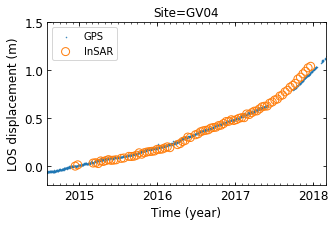

In [39]:
## Plot
print('lat={:.4f}, lon={:.4f}'.format(gps_obj.site_lat, gps_obj.site_lon))
title = 'Site={}'.format(site)
if site_r:
      title += ', Ref Site={}'.format(site_r)
comm_idx = 0
while comm_idx < len(pysar_times):
    if pysar_times[comm_idx] not in gps_times:
        comm_idx += 1
    else:
        break
if comm_idx == len(pysar_times):
    raise RuntimeError('InSAR and GPS do not share ANY date.')

comm_date = pysar_times[comm_idx]
print('Common date: {}'.format(comm_date))
pysar_dis -= pysar_dis[comm_idx]
gps_dis -= gps_dis[gps_times.index(comm_date)]

fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(gps_times, gps_dis, s=0.5**2, label='GPS')
ax.scatter(pysar_times, pysar_dis, s=8**2, facecolors='none', edgecolors=pp.mplColors[1], label='InSAR')
ax = pp.auto_adjust_xaxis_date(ax, ts_obj.yearList)[0]
ax.set_ylim((-0.2, 1.5))
ax.set_xlabel('Time (year)', fontsize=font_size)
ax.set_ylabel('LOS displacement (m)', fontsize=font_size)
ax.set_title(title, fontsize=font_size)
ax.tick_params(which='both', direction='in', labelsize=font_size,
               bottom=True, top=True, left=True, right=True)
ax.tick_params(labelsize=font_size, )
ax.legend(loc='upper left')

out_file = '{}'.format(site)
if site_r:
    out_file += '-{}'.format(site_r)
plt.savefig(out_file+'.jpg', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

In [38]:
comm_idx

83